# **User Identification From Walking Activity**

**Abstract**<br><br>
The dataset collects data from an Android smartphone positioned in the chest pocket. Accelerometer Data are collected from 22 participants walking in the wild over a predefined path. The dataset is intended for Activity Recognition research purposes. It provides challenges for identification and authentication of people using motion patterns.

**Relevant Information**
   - The dataset collects data from an Android smartphone accelerometer positioned in the chest pocket
   - Sampling frequency of the accelerometer: DELAY_FASTEST with network connections disabled
   - Number of Participants: 22
   - Data Format: CSV

**Dataset Information**
   - Data are separated by participant
   - Each file contains the following information
       - time-step, x acceleration, y acceleration, z acceleration

## **Feature selection**
Since the dataset is labeled by participant's ID number, the natural technique to employ for solving this problem is supervised classification. The dataset for each participant is time series of 3 quantities; acceleration in x, y, and z direction (hereafter denoted as $a_x$, $a_y$, and $a_z$) measured by accerometer in an Android cellphone carried in the chest pocket. See the example data for participant 1, 6, and 8 below (22 participants in total).

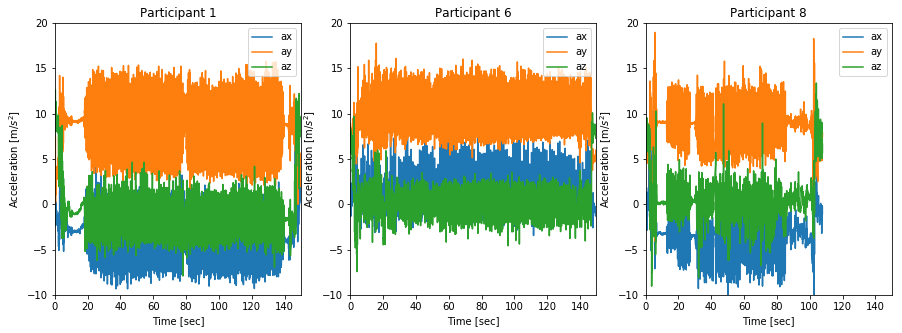

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

# read-in entire dataset
data = []
for i in range( 1, 23 ):
    data.append( pd.read_csv( 'data/%02d.csv'%i, names = [ 't', 'ax', 'ay', 'az' ]) )

# plotting class for repetitive usage
class plotting(object):
    def __init__( self, data ): self.data = data
    def plot_data( self, ID, f, alpha, title, legend=True ):
        f.plot( self.data[ID-1]['t'], self.data[ID-1]['ax'], alpha=alpha, label="ax") # -1 for 0 index
        f.plot( self.data[ID-1]['t'], self.data[ID-1]['ay'], alpha=alpha, label="ay")
        f.plot( self.data[ID-1]['t'], self.data[ID-1]['az'], alpha=alpha, label="az")
        f.set_xlim(0,150)
        f.set_ylim(-10,20)
        f.set_title( title )
        f.set_xlabel( 'Time [sec]' ); f.set_ylabel( r'Acceleration [m/$s^2$]' )
        if legend: f.legend( loc='upper right', fancybox=True )

# example plots for time vs. acceleration for 3 participants
p = plotting(data)
fig = plt.figure(figsize=(15,5))
f = fig.add_subplot(131); p.plot_data( 1, f, 1., 'Participant 1' )
f = fig.add_subplot(132); p.plot_data( 6, f, 1., 'Participant 6' )
f = fig.add_subplot(133); p.plot_data( 8, f, 1., 'Participant 8' )
plt.show()

The time stamp is 0.03 seconds on average (but non-uniformly sampled), and therefore the example participants 1, 6, and 8 above have several thousands of data points for each variable. Many training data points? Well, not quite. Each data point does not have much information and hardly usable as a training data point by itself: time series data have meaning only when they are analyzed as series. The strategy we should take is, then, to *divide each series into smaller segments and use each segment as one data point to extract the features.*

### Mean and Standard Deviation
The simplest features that we first may come up with are *mean* and *standard deviation* of each variable for a given time segment. Figure below shows a series of average value with standard deviation indicated by the error bars, for the above 3 participants with a segmentation size $\Delta T=5$ (sec).

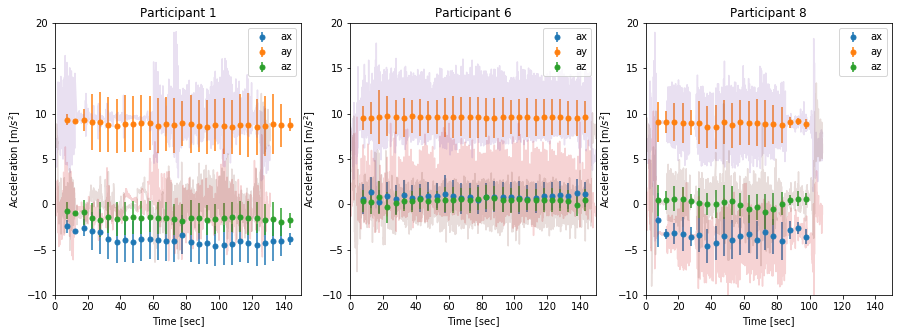

In [80]:
# parsing data into DT
class parse_data(object):
    def __init__( self, data, DT ):
        self.DT = DT
        self.data_parsed = []
        for d in data: self.data_parsed.append(self.parsing( d ))
        self.t_parsed_avg = []
        self.data_parsed_avg = []
        self.sig_parsed_avg = []
        for d in self.data_parsed:
            t_avg, d_avg, sig_avg = self.averaging( d )
            self.t_parsed_avg.append( t_avg )
            self.data_parsed_avg.append( d_avg )
            self.sig_parsed_avg.append( sig_avg )

    def parsing( self, data ):
        t_s = data['t'][0]
        t_e = t_s + self.DT
        i_s = 0
        data_parsed = []
        # need to loop since it's unevely sampled...
        for i, t in enumerate(data['t']):
            if t > t_e:
                data_parsed.append(data.iloc[i_s:i,:])
                i_s = i
                t_e = t + self.DT
        return data_parsed[1:-1]

    def averaging( self, data_parsed ):
        # calculate average and standard dev. for each segment
        t_avg = []; d_avg = []; sig = []
        for d in data_parsed:
            t_avg.append( np.average(d['t']) )
            cols = d.iloc[:,1:]
            d_avg.append( [np.average(cols[col]) for col in cols] )
            sig.append(   [np.std(    cols[col]) for col in cols] )
        d_avg = list(map( list, zip(*d_avg) ))
        sig   = list(map( list, zip(*sig  ) ))
        return t_avg,d_avg,sig

def plot_parse( par, ID, f ):
    t = par.t_parsed_avg[ID-1]; data = par.data_parsed_avg[ID-1]; sig = par.sig_parsed_avg[ID-1]
    f.errorbar( t, data[0], yerr=sig[0], fmt='.', ms=10, label='ax' )
    f.errorbar( t, data[1], yerr=sig[1], fmt='.', ms=10, label='ay' )
    f.errorbar( t, data[2], yerr=sig[2], fmt='.', ms=10, label='az' )
    plt.legend( loc='upper right' )
    

DT = 5. # segment size in second
par = parse_data( data, DT )

fig = plt.figure(figsize=(15,5))
f1 = fig.add_subplot(131); plot_parse( par, 1, f1 )
f2 = fig.add_subplot(132); plot_parse( par, 6, f2 )
f3 = fig.add_subplot(133); plot_parse( par, 8, f3 )

p = plotting( data )
p.plot_data( 2, f1, 0.2, 'Participant 1', legend=False )
p.plot_data( 6, f2, 0.2, 'Participant 6', legend=False )
p.plot_data( 8, f3, 0.2, 'Participant 8', legend=False )
plt.show()

While mean appears to be a nice feature to characterize walking style of a participant in the example above, it should be 0 for $a_x$ and $a_z$ if the segment $\Delta T$ is large compared to the time scale of few walking steps, unless the person in in a circular motion and centrifugal force comes into play. That is to say, any significant offset from 0 is most likely due to systematic errors such as the phone is tilted in the chest pocket or mechanical problems. Likewise, mean value of $a_y$ (acceleration in the vertical direction) is supposed to be equal to the gravitational acceleration ~9.8 for a reasonable value of $\Delta T$. Mean of these variables therefore is not a good choice to be a feature.<br><br>
Standard deviation, on the other hand, is a good candidate to be one of the main features. The figures below show distribution of the 3 example participants in $\sigma_{ax}$, $\sigma_{ay}$, and $\sigma_{az}$ space for $\Delta T=5$ (left) and $1$ sec (right). Unique distributions for each participant are somewhat visible for this particular set of participants, but further features would need to be added once we increase the number of the participants.

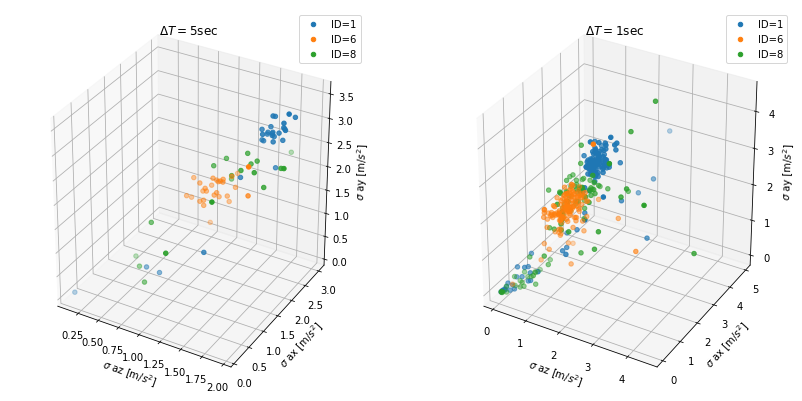

In [81]:
def plot_scatt(data,ID,f,title):
    f.scatter(data[ID[0]-1][2],data[ID[0]-1][0],data[ID[0]-1][1],label='ID=%d'%(ID[0]))
    f.scatter(data[ID[1]-1][2],data[ID[1]-1][0],data[ID[1]-1][1],label='ID=%d'%(ID[1]))
    f.scatter(data[ID[2]-1][2],data[ID[2]-1][0],data[ID[2]-1][1],label='ID=%d'%(ID[2]))
    f.set_xlabel(r'$\sigma$ az [m/$s^2$]')
    f.set_ylabel(r'$\sigma$ ax [m/$s^2$]')
    f.set_zlabel(r'$\sigma$ ay [m/$s^2$]')
    f.set_title(title)
    plt.legend()

fig = plt.figure(figsize=(14,7))
ID=[1,6,8]

par = parse_data( data, 5 ) # segment size = 5sec
plot_scatt( par.sig_parsed_avg, ID, fig.add_subplot(121,projection='3d'), r"$\Delta T=5$sec")
par = parse_data( data, 1 ) # segment size = 1sec
plot_scatt( par.sig_parsed_avg, ID, fig.add_subplot(122,projection='3d'), r"$\Delta T=1$sec")

### Frequency
Fourier analysis is essential in characterising walking style of the participants. Ideally we want to find a method to somehow parameterize the "shape" of the Fourier spectrum for each participant, but for now we stick to the temporal frequency of steps (number of steps per second) which is relatively easy to identify and very likely a strong feature.<br>
Here we choose magnitude of mean-subtracted acceleration to be a variable to measure walking frequency, $f$: for a given time segment, $|a|(t)=\sqrt{(a_x(t)-\bar{a_x})^2+(a_y(t)-\bar{a_y})^2+(a_z(t)-\bar{a_z})^2}$, where $\bar{a_x}$ is mean value of $a_x(t)$. Because the data is unevenly sampled in time, we use Lomb-Scargle periodogram which well approximates Fourier transform in our case. Note that mean value and standard deviation of $|a|$ also could be nice features. It is similar to $\sigma_{ax,ay,az}$ but directional information is reduced.<br>
As an example, the plots below show $|a|(t)$ in 10th time segment ($\Delta T=5$sec) of participant 8 (left), its periodogram with the peak frequency marked by the vertical line (center), and time sequence of the peak frequency with the 10th time segment is marked by the red dot (right).  

/usr/local/lib/python3.5/dist-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Text(0.5,1,'Time vs. Peak frequency')

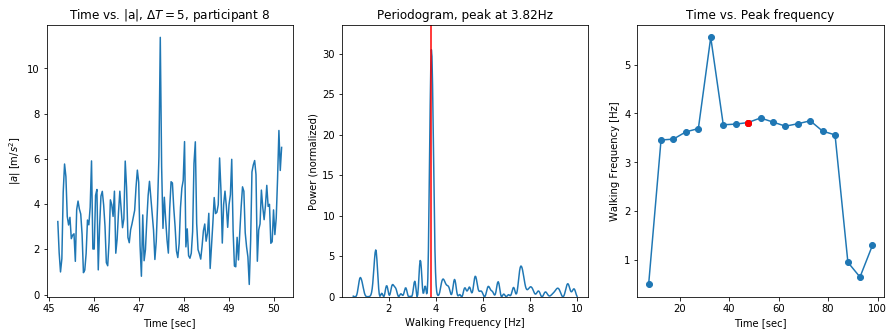

In [82]:
from gatspy.periodic import LombScargleMultibandFast

class Period(object):

    def get_a(self,par,ID):
        dp = par.data_parsed[ID-1]
        n_seg = len(dp)
        a=[]; t=[]
        for i_seg in range(n_seg):
            ax = dp[i_seg]['ax'] - np.average(dp[i_seg]['ax'])
            ay = dp[i_seg]['ay'] - np.average(dp[i_seg]['ay'])
            az = dp[i_seg]['az'] - np.average(dp[i_seg]['az'])
            amag = np.sqrt(ax**2+ay**2+az**2)
            a.append(amag)
            t.append(dp[i_seg]['t'])
        return(t,a)

    def get_LS(self, y ):
        N = len(y[0])
        model = LombScargleMultibandFast().fit(y[0], y[1])

        T = y[0][-1]-y[0][0]
        fmin = 1./T
        fmax = N/(2.*T)
        df = fmin/8.
        f = np.arange(fmin,fmax,df)
        periods = 1./f
        power = model.score(periods)

        power *= N/2 # make it equal to the normalized periodogram of NR eq. 13.8.4
        return [f, power]

    def get_fp(self,t,a,iseg):
        ti = np.array(t[iseg]); ai = np.array(a[iseg])
        f,p = self.get_LS([ti,ai])

        li = (f>1/2.)*(f<1/0.1) # period faster than 2sec, slower than 0.1sec
        ff=f[li]; fp=p[li]
        period = ff[np.argmax(fp)]
        return ti,ai,ff,fp,period

    def get_peaks(self,par,ID):
        t,a=get_a(par,ID)
        tseg=[]; aseg=[]; sseg=[]; pseg=[]
        for iseg in range(len(t)):
            ti,ai,ff,fp,period = self.get_fp(t,a,iseg)
            tseg.append(np.average(ti))
            aseg.append(np.average(ai))
            sseg.append(np.std(ai))
            pseg.append(period)
        return tseg,aseg,sseg,pseg

DT = 5. # segment size in second
par = parse_data( data, DT )
ID = 8
iseg = 8
per = Period()

fig = plt.figure(figsize=(15,5))
f1 = fig.add_subplot(131)
t,a = per.get_a(par,ID)
f1.plot(t[iseg],a[iseg])
f1.set_xlabel('Time [sec]')
f1.set_ylabel(r'$|a|$ [m/$s^2$]')
f1.set_title(r'Time vs. |a|, $\Delta T=5$, participant 8')

f2 = fig.add_subplot(132)
ti,ai,ff,fp,period = per.get_fp(t,a,iseg)
f2.plot(ff,fp)
f2.set_xlabel('Walking Frequency [Hz]')
f2.set_ylabel('Power (normalized)')
f2.set_title('Periodogram, peak at 3.82Hz')
ymax = np.max(fp)*1.1
f2.set_ylim(0,ymax)
f2.plot([period,period],[0,ymax],'r')

f3 = fig.add_subplot(133)
tseg,aseg,sseg,pseg=per.get_peaks(par,ID)
f3.plot(tseg,pseg,'o-')
f3.plot([tseg[iseg],tseg[iseg]],[pseg[iseg],pseg[iseg]],'ro')
f3.set_xlabel('Time [sec]')
f3.set_ylabel('Walking Frequency [Hz]')
f3.set_title('Time vs. Peak frequency')

As the right plot shows, participant 8 can be well characterized by ~3.7Hz of walking frequency except several outliers. Below is a scatter plot of the peak frequency and mean value of $|a|$ for the participant 1,6 and 8. It is apparent that the walking frequency is very strong feature. There is a big inaccuracy in finding the walking frequency $f$ (just pick the frequency of the highest power in the reasonable frequency range) and often end up with wrong result, which definitely need to be improved. 

/usr/local/lib/python3.5/dist-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


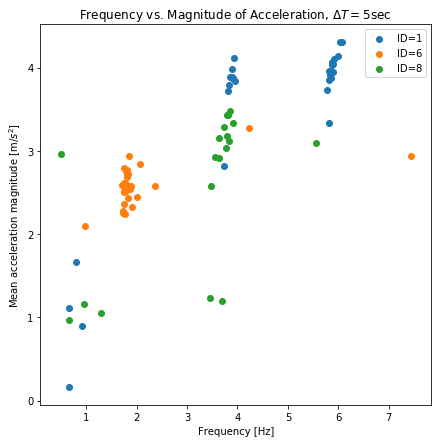

In [71]:
DT = 5. # segment size in second
par = parse_data( data, DT )
ID = [1,6,8]
per = Period()

fig = plt.figure(figsize=(7,7))
f = fig.add_subplot(111)
tseg,aseg,sseg,pseg=per.get_peaks(par,ID[0]); f.scatter(pseg,aseg,label='ID=%d'%ID[0])
tseg,aseg,sseg,pseg=per.get_peaks(par,ID[1]); f.scatter(pseg,aseg,label='ID=%d'%ID[1])
tseg,aseg,sseg,pseg=per.get_peaks(par,ID[2]); f.scatter(pseg,aseg,label='ID=%d'%ID[2])
f.set_xlabel('Frequency [Hz]')
f.set_ylabel(r'Mean acceleration magnitude [m/$s^2$]')
f.set_title(r'Frequency vs. Magnitude of Acceleration, $\Delta T=5$sec')
plt.legend()

## **Result of Supervised Classification**
For this preliminary analysis, the features we are going to use are standard deviation of acceleration in each direction, $\sigma_x$, $\sigma_y$, $\sigma_z$, and walking frequency (number of walking steps per second), $f$. We train the classifiers using randomly chosen 80% of all the time segments for a given segmentation size, and test using the remaining 20% to see if the classifier can identify the participant. F1-Scores calculated below are average of 100 scores from different test sets. We include 19 participants in this classification. All the classifiers used here are from scikit-learn.<br>

**K-Nearest Neighbors**<br>
F1-Score = **57.8%**<br>
Best "number of neighbor points (n_neighbors)" = 5<br>

**Decision Tree**<br>
F1-Score = **48.5%**<br>
Best "minimum number of samples required to split tree (min_samples_split)" = 2<br>

**Random Forest**<br>
F1-Score = **56.3**<br>
Best min_samples_split = 3<br>

**Supported Vector Machine**<br>
F1-Score = **59.4%** (kernel=RBF)<br>
F1-Score = **55.6%** (kernel=Polynomial)<br>
best "penalty parameter (C)" = 10<br>

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

DT = 5. # segment size in second
par = parse_data( data, DT )

ID = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,19,21]
pseg=[]; sigx=[]; sigy=[]; sigz=[]; labels=[]
for i, i_d in enumerate(ID):
    print('Processing participant %d'%i_d)
    tseg,aseg,sseg,pseg_temp = get_peaks(par,i_d)
    pseg.append( pseg_temp )
    sigx.append( par.sig_parsed_avg[i_d-1][0] )
    sigy.append( par.sig_parsed_avg[i_d-1][1] )
    sigz.append( par.sig_parsed_avg[i_d-1][2] )
    labels.append( np.ones((len(tseg)),dtype=int)*i_d )

pseg = [ i for pseg_n in pseg for i in pseg_n]
sigx = [ i for sigx_n in sigx for i in sigx_n]
sigy = [ i for sigy_n in sigy for i in sigy_n]
sigz = [ i for sigz_n in sigz for i in sigz_n]

features = np.transpose([pseg,sigx,sigy,sigz]) #63, 59, 57, n_neighbors=5

labels = [ i for labels_n in labels for i in labels_n]

avg = 0.
navg = 100
for cnt in range(navg):
    features_train, features_test, labels_train, labels_test =\
        train_test_split(features, labels, test_size=0.3, random_state=int(random.random()*1000))

    # Classifiers
    clf = KNeighborsClassifier(n_neighbors=5)
    #clf = DecisionTreeClassifier(min_samples_split=2)
    #clf = SVC(C=10)#,kernel='poly')
    #clf = RandomForestClassifier(min_samples_split=3)

    clf.fit( features_train, labels_train )
    labels_pred = clf.predict( features_test )
    acc = accuracy_score(labels_pred,labels_test)
    f1s = f1_score(labels_pred,labels_test,average='micro')
    avg += f1s
avg /= navg
print('Average F1 Score = %f'%avg)


/usr/local/lib/python3.5/dist-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "
